In [1]:
# System 

# heater 
# common HVAC duct sizes update ducts (2 foot diameter ducting)

In [2]:
from general import *
from generation_stm import *
from storage_stm import *
from system_stm import *
from loaddata import calculate_greenhouse_load
from one_D_model import *
from datetime import datetime, timedelta
import os, shutil
import matplotlib.dates as mdates

In [3]:
##### exergy efficiency vs min useful temp ##### 

In [4]:
geometry_data = {
    '3-1':   {'tank_cost': 630, 'insulation_cost': 3,  'exergy_efficiency': .602, 'rR': 0.574},
    '2.5-1': {'tank_cost': 630, 'insulation_cost': 6,  'exergy_efficiency': .625, 'rR': 0.606},
    '2-1':   {'tank_cost': 630, 'insulation_cost': 6,  'exergy_efficiency': .648, 'rR': 0.648},
    '1.5-1': {'tank_cost': 630, 'insulation_cost': 8,  'exergy_efficiency': .672, 'rR': 0.708},
    '1-1':   {'tank_cost': 630, 'insulation_cost': 19, 'exergy_efficiency': .696, 'rR': 0.804},
    '1-1.5': {'tank_cost': 630, 'insulation_cost': 34, 'exergy_efficiency': .707, 'rR': 0.914},
    '1-2':   {'tank_cost': 630, 'insulation_cost': 51, 'exergy_efficiency': .707, 'rR': 1.0019},
    '1-2.5': {'tank_cost': 630, 'insulation_cost': 71, 'exergy_efficiency': .704, 'rR': 1.077},
    '1-3':   {'tank_cost': 630, 'insulation_cost': 90, 'exergy_efficiency': .698, 'rR': 1.142},
}

In [5]:
# get load data
current_dir = os.getcwd()
original_weather_file = "C:\\Users\\tljohn\\Desktop\\RPB Micmaq\\code\\presque_isle_main_tmy.csv"

num_copies = 1
Kfiles = []
# creating multiple copies of the original weather file
for i in range(num_copies):
    new_file = os.path.join(current_dir, f'presque_isle_main_tmy_{i}.csv')
    shutil.copyfile(original_weather_file, new_file)
    Kfiles.append(new_file)
weather_files = Kfiles
greenhouse_load = calculate_greenhouse_load(weather_files)
ambient_temps = greenhouse_load['T_amb']
T_greenhouse = greenhouse_load['T_greenhouse']
greenhouse_load = greenhouse_load[['NetLoad_MW']]
ambient_temps = ambient_temps[1]
greenhouse_load_arr = greenhouse_load.to_numpy()
greenhouse_load_arr = greenhouse_load_arr.flatten()
date_range = pd.date_range(start='2033-01-01 00:30:00', periods=len(greenhouse_load_arr), freq='h')
greenhouse_load = pd.DataFrame({'load_MW': greenhouse_load_arr}, index=date_range)
greenhouse_load.index.name = 'Date/time'
ambient_temps = pd.DataFrame(ambient_temps, index=greenhouse_load.index, columns=['T_amb'])
ambient_temps.index.name = 'Date/time' 

Total Q_net for the year: -287.74 MWh


c:\Users\tljohn\Desktop\RPB Micmaq\code\loaddata.py:123: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2023-01-01', periods=num_hours, freq=f'{timestep_hours}H')
C:\Users\tljohn\AppData\Local\Temp\ipykernel_20028\442827168.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ambient_temps = ambient_temps[1]


In [ ]:
max_greenhouse_load = np.max(greenhouse_load_arr)
power_block_size = max_greenhouse_load

In [7]:
##########################################################################################################################################################################################################

In [ ]:
# --- fixed finance knobs per your spec ---
set_finance_params(COE=0.065, DF=1.0, grant_frac=0.25)  # cost of equity, all-debt, grant 25%
ITC = 0.50                                              # pass into System(...)
 
PV_capacity_AC_grid = [
    0.005, 0.031, 0.057, 0.083, 0.109,
    0.135, 0.161, 0.187, 0.213, 0.239,
    0.266, 0.292, 0.318, 0.344, 0.370,
    0.396, 0.422, 0.448, 0.474, 0.500
]

# --- fixed TES: 200 kWh, geometry 1-1.5 ---
geometry_data = {
    '1-1.5': {'tank_cost': 630, 'insulation_cost': 34, 'exergy_efficiency': 0.707, 'rR': 0.914},
}
ar = '1-1.5'
geo  = geometry_data[ar]
# be robust: treat values >1 as percentages, ≤1 as fractions
eff_raw = geo['exergy_efficiency']
eff = eff_raw if eff_raw <= 1.0 else eff_raw / 100.0
cost = geo['insulation_cost']
tank = geo['tank_cost']
rR   = geo['rR']

# --- constants that don’t change across PV sizes ---
ratio_MW2acres = {'SAT': 0.24, 'fixed': 0.35}
pv_type = 'fixed'
pv_dc2ac = 1.2 
POI_limit = 0   # NOTE: if you want to treat *all excess* as curtailment (no export), set to 0
analysis_period = 25

# Site
NSTTF_site = Site('NSTTF', Weather_Data(Kfiles), -7, POI_limit=POI_limit)

# TES (fixed capacity)
TES_capacity_e = 200/1000   # 200 kWh -> 0.200 MWh
power_block = power_block_size  # keep your existing PB
df_sweep_PV = []

for PV_capacity_AC in PV_capacity_AC_grid:
    PV_capacity_DC = PV_capacity_AC * pv_dc2ac
    resistive_charge_rate = PV_capacity_DC

    # PV system (fresh instance each size)
    ASGARD_PV = PV_System(
        name='ASGARD_PV',
        site=NSTTF_site,
        capacity_MW_DC=PV_capacity_DC,
        PV_array_type=pv_type,
        PV_tilt=30,
        PV_azimuth=180,
        ratio_DC2AC=pv_dc2ac,
        off_grid_operation=False,
        power_priority_load_MW_AC=None
    )

    # TES system (fixed 200 kWh; same geometry)
    ASGARD_TES = TES_System_STM(
        name=f'ASGARD_TES_{ar}',
        site=NSTTF_site,
        capacity_MWh_t=TES_capacity_e/0.98,
        power_rating_MW_e=power_block,
        power_minimum_MW_e=0,
        efficiency_rating_t2e=eff,
        percent_discharge_depth=100,
        percent_heat_loss_daily=3,
        charge_rate_CSP_MW_t=0,
        charge_efficiency_t2TES=1,
        charge_rate_resistive_MW_e=resistive_charge_rate,
        charge_efficiency_e2TES=0.98,
        systems_charging=['ASGARD_PV'],
        start_full=False,
        off_grid_operation=True,
        DOE_2030_targets=False,
        tank_cost=tank,
        insulation_cost=cost,
        exergy_efficiency=eff,
        rR=rR
    )

    # Build and run
    systems = [ASGARD_PV, ASGARD_TES]
    sim = System(
        load_MW=greenhouse_load,
        systems_load_order=systems,
        analysis_period=analysis_period,
        ITC=ITC
    )
    m = sim.metrics
    print(*m)
    # Pull PV curtailment/export and generation from the timeseries/metrics
    ts = sim.timeseries
    pv_name = ASGARD_PV.name
    
    df_sweep_PV.append({
    'PV_capacity_AC_MW': PV_capacity_AC,
    'PV_capacity_DC_MW': PV_capacity_DC,
    'COE': 0.065,
    'ITC': 0.50,
    'DF': 1.0,
    'GRANT': 0.25,
    'aspect_ratio': ar,
    #'rR': rR,
    'LCOE_[$/kWh_e]': m['LCOE_real_USD_kWh'],
    'TES_to_load_MWh_e': m['TES_System_STM_to_load_MWh_e'],
    'TES_thermal_loss_MWh_t': m['TES_System_STM_thermal_loss_MWh_t'],
    'ASGARD_PV_curtailed_MWh_e': m['PV_System_curtailed_MWh_e'],
    'PV_System_energy_MWh_AC' : m['PV_System_energy_MWh_AC'],
    'load_annual_MWh': m['load_annual_MWh'],
    'fuel_to_load_annual_MWh_th' : m['fuel_to_load_annual_MWh_th'],
    'system_to_load_annual_MWh_th' : m['system_to_load_annual_MWh_th']
})

df_sweep_PV = pd.DataFrame(df_sweep_PV)
print(df_sweep_PV)

# Best by LCOE
best = df_sweep_PV.loc[df_sweep_PV['LCOE_[$/kWh_e]'].idxmin()]
print("\nBest by LCOE:\n", best)

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09483041435734925' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,'fuel_to_load_MWh_th'] = unmet_load_MW
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:386: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.08729253894306e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_to_'+tes.name+'_MWh_e'] = pv2tes
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:399: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.9855466881641986e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:413: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0189302469978024' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_curtailed_MWh_e'] = max([0,pv_remaining-max([0,poi_remaining])])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micm

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:386: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0029709788427427467' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_to_'+tes.name+'_MWh_e'] = pv2tes
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:399: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0029115592658878918' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,tes.name+'_MWh_t'] = tes_MWh_t
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:259: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.6394490823598643e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:413: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20218908757310172' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_curtailed_MWh_e'] = max([0,pv_remaining-max([0,poi_remaining])])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Mic

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:413: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2357467194571417' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_curtailed_MWh_e'] = max([0,pv_remaining-max([0,poi_remaining])])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micm

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an erro

hourly_PV_to_load_MWh hourly_TES_to_load_MWh hourly_Fuel_to_load_MWh PV_systems CSP_systems BES_systems TES_systems years PV_capex_USD CSP_capex_USD TES_capex_USD BES_capex_USD system_capex_USD off_grid_systems load_MWh load_annual_MWh ASGARD_PV_capacity_MW_DC PV_System_capacity_MW_DC ASGARD_PV_capacity_MW_AC PV_System_capacity_MW_AC ASGARD_TES_1-1.5_capacity_MWh_t TES_System_STM_capacity_MWh_t ASGARD_TES_1-1.5_capacity_MWh_e TES_System_STM_capacity_MWh_e ASGARD_TES_1-1.5_charge_rate_resistive_MW_e ASGARD_TES_1-1.5_power_rating_MW_e ASGARD_PV_area_land_acres PV_System_area_land_acres ASGARD_TES_1-1.5_area_land_acres TES_System_STM_area_land_acres system_area_land_acres ASGARD_PV_capex_USD PV_System_capex_USD ASGARD_TES_1-1.5_capex_USD TES_System_STM_capex_USD ASGARD_PV_annual_OM_USD PV_System_annual_OM_USD ASGARD_TES_1-1.5_annual_OM_USD TES_System_STM_annual_OM_USD system_annual_OM_USD ASGARD_PV_energy_MWh_AC PV_System_energy_MWh_AC PV_System_energy_MWh_t ASGARD_PV_to_load_MWh_e PV_Sys

c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:779: RuntimeWarning: invalid value encountered in scalar divide
  Rv = ((((1 + metrics['WACC_r']) ** metrics['analysis_period']) * ((1 - NPV_renewables_N / NPV_renewables_L) * (metrics['system_capex_USD'] * (1 - (tax * metrics['PVD']) * (1 - metrics['ITC'] / 2) - metrics['ITC'])) + (NPV_OM_N + NPV_htr_ARMO_N + NPV_batt_ARMO_N) -
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:780: RuntimeWarning: invalid value encountered in scalar divide
  (NPV_renewables_N / NPV_renewables_L) * (NPV_OM_L + NPV_htr_ARMO_L + NPV_batt_ARMO_L)))) / ((1 + metrics['WACC_r']) ** metrics['analysis_period'])


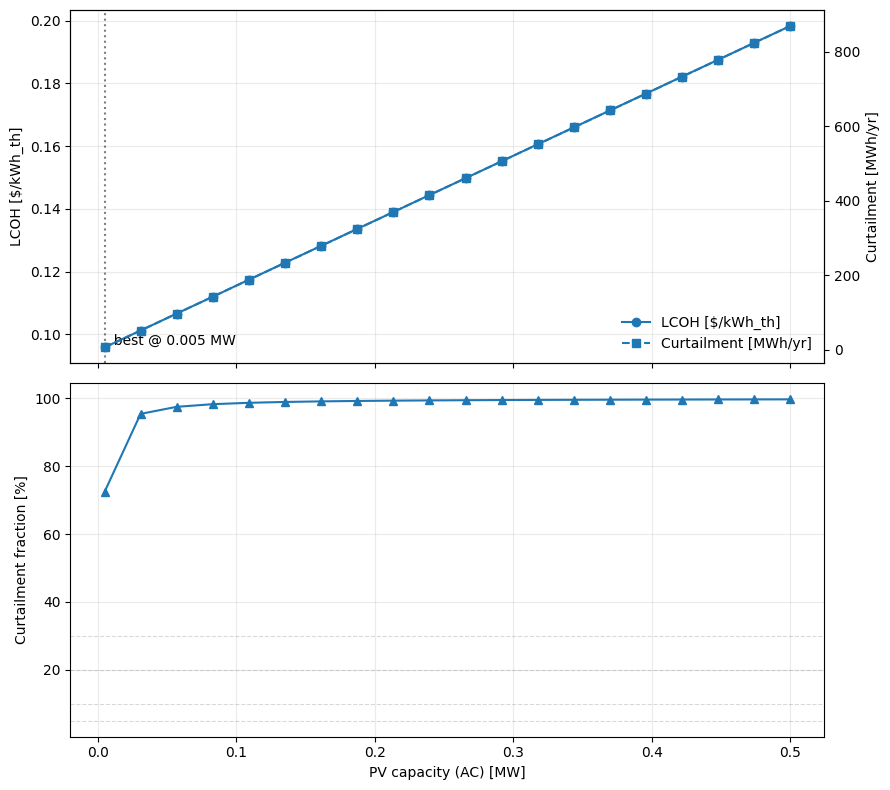

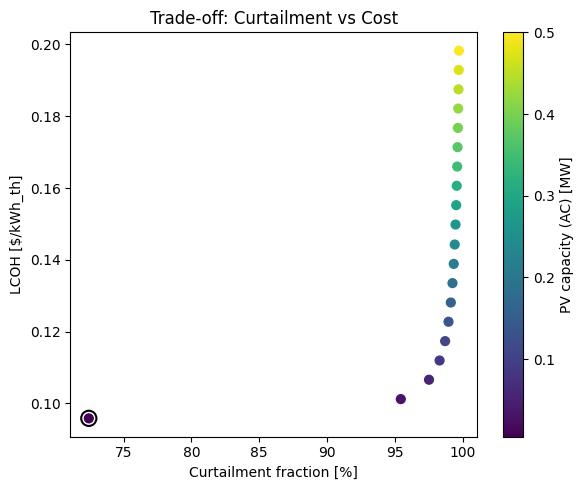


Top 5 by lowest cost:
 PV_AC_MW     LCOH  Curtail_MWh  Curtail_%
    0.005 0.095814     6.314694       72.4
    0.031 0.101172    51.576680       95.4
    0.057 0.106573    96.899947       97.5
    0.083 0.111932   142.226988       98.3
    0.109 0.117333   187.554624       98.7


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _pick(df, prefer):
    for c in prefer:
        if c in df.columns: return c
    # fallback: fuzzy search
    lc = [c for c in df.columns if any(p.lower() in c.lower() for p in prefer)]
    if lc: return lc[0]
    raise ValueError(f"Couldn't find any of: {prefer}")

def _pick_lcoh(df):
    return _pick(df, ['LCOH_[$/kWh_th]','LCOH_real_USD_per_kWh_th','LCOE_[$/kWh_e]','LCOE_real_USD_kWh'])

def _pick_curt(df):
    # prefer PV_System_* then ASGARD_*
    return _pick(df, ['PV_System_curtailed_MWh_e','ASGARD_PV_curtailed_MWh_e','curtailed'])

def _pick_pvgen(df):
    return _pick(df, ['PV_System_energy_MWh_AC','ASGARD_PV_energy_MWh_AC','PV_energy'])

def summarize_and_plot_pv_sweep(df_sweep_PV, metric_label='LCOH [$/kWh_th]'):
    df = df_sweep_PV.copy()
    lcoh_col = _pick_lcoh(df)
    cur_col  = _pick_curt(df)
    gen_col  = _pick_pvgen(df)
    size_col = _pick(df, ['PV_capacity_AC_MW','PV_capacity_MW','PV_AC_MW'])

    # numeric
    for c in [lcoh_col, cur_col, gen_col, size_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # sort by PV size
    df = df.sort_values(size_col).reset_index(drop=True)

    # curtailment fraction
    eps = 1e-12
    df['curtailment_frac'] = df[cur_col] / (df[gen_col] + eps)

    # best by LCOH
    best_idx = df[lcoh_col].idxmin()
    best = df.loc[best_idx, [size_col, lcoh_col, cur_col, 'curtailment_frac']]

    # ---- Plots ----
    fig, axes = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

    # (1) Dual-axis: LCOH & Curtailment MWh vs PV size
    ax1 = axes[0]
    ln1 = ax1.plot(df[size_col], df[lcoh_col], marker='o', label=metric_label)
    ax1.set_ylabel(metric_label)
    ax1.grid(alpha=0.25)

    ax1b = ax1.twinx()
    ln2 = ax1b.plot(df[size_col], df[cur_col], marker='s', linestyle='--', label='Curtailment [MWh/yr]')
    ax1b.set_ylabel('Curtailment [MWh/yr]')

    # one legend combining both axes
    lines = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', frameon=False)

    # annotate best
    ax1.axvline(df.loc[best_idx, size_col], color='k', ls=':', alpha=0.5)
    ax1.text(df.loc[best_idx, size_col], df.loc[best_idx, lcoh_col],
             f"  best @ {df.loc[best_idx, size_col]:.3f} MW",
             va='bottom')

    # (2) Curtailment fraction vs PV size
    ax2 = axes[1]
    ax2.plot(df[size_col], 100*df['curtailment_frac'], marker='^')
    ax2.set_ylabel('Curtailment fraction [%]')
    ax2.set_xlabel('PV capacity (AC) [MW]')
    ax2.grid(alpha=0.25)
    # useful guide lines
    for y in (5, 10, 20, 30):
        ax2.axhline(y, color='gray', ls='--', lw=0.8, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # (3) Pareto view: LCOH vs Curtailment fraction
    plt.figure(figsize=(6,5))
    plt.scatter(100*df['curtailment_frac'], df[lcoh_col], c=df[size_col], s=40)
    plt.xlabel('Curtailment fraction [%]')
    plt.ylabel(metric_label)
    plt.title('Trade-off: Curtailment vs Cost')
    cbar = plt.colorbar()
    cbar.set_label('PV capacity (AC) [MW]')
    # annotate best
    plt.scatter(100*df.loc[best_idx, 'curtailment_frac'], df.loc[best_idx, lcoh_col],
                edgecolor='k', facecolor='none', s=120, lw=1.5)
    plt.tight_layout()
    plt.show()

    # Top-5 table (quick text summary)
    top = (df[[size_col, lcoh_col, cur_col, 'curtailment_frac']]
           .sort_values(lcoh_col)
           .head(5)
           .rename(columns={size_col:'PV_AC_MW', lcoh_col:'LCOH', cur_col:'Curtail_MWh', 'curtailment_frac':'Curtail_%'}))
    top['Curtail_%'] = (100*top['Curtail_%']).round(1)
    print("\nTop 5 by lowest cost:")
    print(top.to_string(index=False))

# ---- usage ----
summarize_and_plot_pv_sweep(df_sweep_PV)


In [35]:
type(df_sweep_PV)

pandas.core.frame.DataFrame

In [36]:
out_dir = r"C:\\Users\\tljohn\\Desktop\\RPB Micmaq"
os.makedirs(out_dir, exist_ok=True)

df_sweep_PV.to_csv(os.path.join(out_dir, 'PVsweepdata.csv'), index=False)

In [28]:
df = pd.DataFrame()
# TEA system setup
ratio_MW2acres = {'SAT': 0.24, 'fixed': 0.35}
pv_type = 'fixed'
pv_dc2ac = 1.2 
POI_limit = None  
analysis_period = 25  
ITC = 0.3  

geometry_data = {
    '1-1.5': {'tank_cost': 630, 'insulation_cost': 34, 'exergy_efficiency': .707, 'rR': 0.914},
}

# Setup Site and Systems
NSTTF_site = Site('NSTTF', Weather_Data(Kfiles), -7, POI_limit=POI_limit)
power_block = power_block_size # MW
PV_capacity_AC = 0.1 
PV_capacity_DC = PV_capacity_AC * pv_dc2ac  
ASGARD_PV = PV_System(
    name='ASGARD_PV',
    site=NSTTF_site,
    capacity_MW_DC=PV_capacity_DC,
    PV_array_type=pv_type,
    PV_tilt=30,
    PV_azimuth=180,
    ratio_DC2AC=pv_dc2ac,
    off_grid_operation=False,
    power_priority_load_MW_AC=None
)

TES_capacity_e = 200/1000 # MWh
resistive_charge_rate = PV_capacity_DC

aspect_ratios = list(geometry_data.keys())

all_timeseries = {}

all_LCOH = {}

COE_grid    = [0.065, 0.13, 0.26]
DF_grid     = [0.0, 0.5, 1.0]
GRANT_grid  = [0.00, 0.10, 0.25]

rows = []
for COE in COE_grid:
    for DF in DF_grid:
        for GR in GRANT_grid:
            set_finance_params(COE=COE, DF=DF, grant_frac=GR)
            for ITC in [0.0, 0.30, 0.50]:
                # choose one AR (or loop ARs outside if you want a 5th dimension)
                ar = aspect_ratios[0]
                geo  = geometry_data[ar]
                eff  = geo['exergy_efficiency'] / 100.0
                cost = geo['insulation_cost']; tank = geo['tank_cost']; rR = geo['rR']

                ASGARD_TES = TES_System_STM(
                    name=f'ASGARD_TES_{ar}',
                    site=NSTTF_site,
                    capacity_MWh_t=TES_capacity_e/0.98,
                    power_rating_MW_e=power_block,
                    power_minimum_MW_e=0,
                    efficiency_rating_t2e=eff,
                    percent_discharge_depth=100,
                    percent_heat_loss_daily=3,
                    charge_rate_CSP_MW_t=0,
                    charge_efficiency_t2TES=1,
                    charge_rate_resistive_MW_e=resistive_charge_rate,
                    charge_efficiency_e2TES=0.98,
                    systems_charging=['ASGARD_PV'],
                    start_full=False,
                    off_grid_operation=True,
                    DOE_2030_targets=False,
                    tank_cost=tank,
                    insulation_cost=cost,
                    exergy_efficiency=eff,
                    rR=rR
                )

                systems = [ASGARD_PV, ASGARD_TES]
                sim = System(
                load_MW=greenhouse_load,
                systems_load_order=[ASGARD_PV, ASGARD_TES],
                analysis_period=25,
                ITC=ITC
            )
                m = sim.metrics

                rows.append({
                    'COE': COE,
                    'ITC': ITC,
                    'DF': DF,
                    'GRANT': GR,
                    'LCOE_[$/kWh_e]': m['LCOE_real_USD_kWh'],
                    'aspect_ratio': ar,
                    'rR': rR
                })

df_sweep = pd.DataFrame(rows)
print(df_sweep.head())


c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09483041435734925' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,'fuel_to_load_MWh_th'] = unmet_load_MW
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:313: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010174585077886119' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_to_load_MWh_e'] = pv2l
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:414: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010174585077886119' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i

     COE  ITC   DF  GRANT  LCOE_[$/kWh_e] aspect_ratio     rR
0  0.065  0.0  0.0    0.0        0.127393        1-1.5  0.914
1  0.065  0.3  0.0    0.0        0.118055        1-1.5  0.914
2  0.065  0.5  0.0    0.0        0.111829        1-1.5  0.914
3  0.065  0.0  0.0    0.1        0.123937        1-1.5  0.914
4  0.065  0.3  0.0    0.1        0.115532        1-1.5  0.914


c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:861: RuntimeWarning: invalid value encountered in divide
  hourly_RES_LMP = 100 * np.array(metrics['hourly_RES_to_load']) / np.array(load_series)


In [29]:
out_dir = r"C:\\Users\\tljohn\\Desktop\\RPB Micmaq"
os.makedirs(out_dir, exist_ok=True)

df_sweep.to_csv(os.path.join(out_dir, 'heatmapdata.csv'), index=False)

Best by LCOE_[$/kWh_e]:
COE                 0.065
ITC                   0.5
DF                    1.0
GRANT                0.25
LCOE_[$/kWh_e]    0.10606
aspect_ratio        1-1.5
rR                  0.914
Name: 26, dtype: object


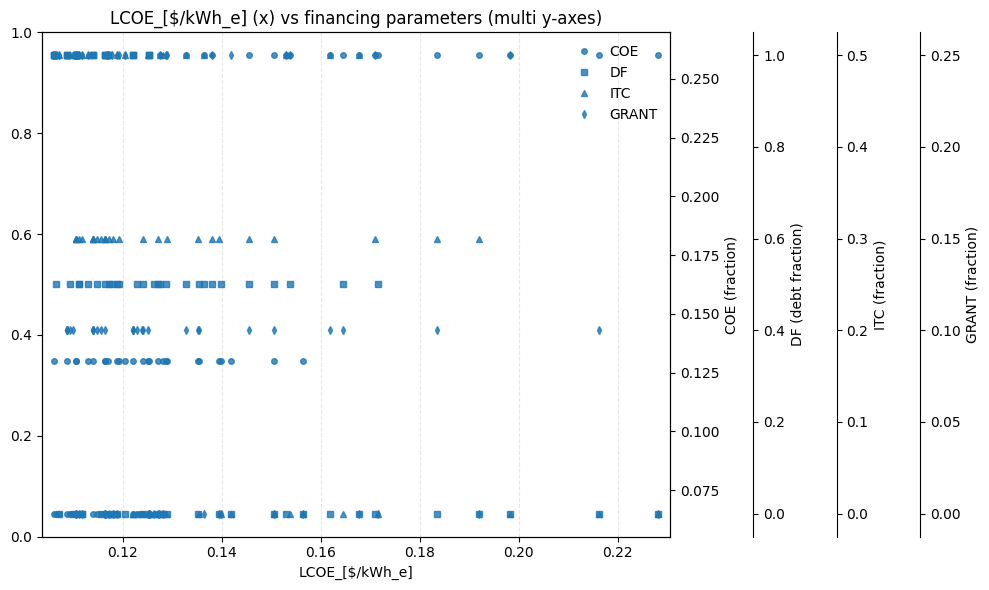

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _pick_value_col(df):
    # auto-detect LCOE/LCOH column
    candidates = [
        'LCOE_[$/kWh_e]',
        'LCOE_real_USD_kWh',
        'LCOH_[$/kWh_th]',
        'LCOH_real_USD_per_kWh_th',
    ]
    for c in candidates:
        if c in df.columns:
            return c
    for c in df.columns:
        if 'LCOE' in c or 'LCOH' in c:
            return c
    raise ValueError("Couldn't find an LCOE/LCOH column in df_sweep")

def plot_lcoe_vs_finance_multi_yaxes(df_sweep, value_col=None):
    df = df_sweep.copy()
    value_col = value_col or _pick_value_col(df)

    # Basic type cleanup
    for col in ['COE','DF','ITC','GRANT', value_col]:
        df[col] = df[col].astype(float)

    # Sort by x for nicer plotting
    df.sort_values(value_col, inplace=True)

    # Print global best
    best_idx = df[value_col].idxmin()
    print("Best by {}:".format(value_col))
    print(df.loc[best_idx])

    # Figure + multiple right y-axes
    fig, axx = plt.subplots(figsize=(10,6))
    axx.set_xlabel(value_col)
    axx.set_title(f"{value_col} (x) vs financing parameters (multi y-axes)")

    # Create 4 twinx axes
    ax_coe  = axx.twinx()
    ax_df   = axx.twinx()
    ax_itc  = axx.twinx()
    ax_gr   = axx.twinx()

    # Offset the extra right spines so they don't overlap
    ax_df.spines["right"].set_position(("outward", 60))
    ax_itc.spines["right"].set_position(("outward", 120))
    ax_gr.spines["right"].set_position(("outward", 180))

    # Make extra axes frames invisible except their right spine
    def _only_right_spine(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for s in ax.spines.values():
            s.set_visible(False)
        ax.spines['right'].set_visible(True)

    _only_right_spine(ax_df)
    _only_right_spine(ax_itc)
    _only_right_spine(ax_gr)

    # Plot scatters for each param against LCOE/LCOH
    h1 = ax_coe.plot(df[value_col], df['COE'],  'o', markersize=4, alpha=0.8, label='COE')
    h2 = ax_df.plot (df[value_col], df['DF'],   's', markersize=4, alpha=0.8, label='DF')
    h3 = ax_itc.plot(df[value_col], df['ITC'],  '^', markersize=4, alpha=0.8, label='ITC')
    h4 = ax_gr.plot (df[value_col], df['GRANT'],'d', markersize=4, alpha=0.8, label='GRANT')

    # Axis labels
    ax_coe.set_ylabel('COE (fraction)')
    ax_df.set_ylabel('DF (debt fraction)')
    ax_itc.set_ylabel('ITC (fraction)')
    ax_gr.set_ylabel('GRANT (fraction)')

    # Nice x-limits/padding
    xmin, xmax = df[value_col].min(), df[value_col].max()
    dx = (xmax - xmin) if xmax > xmin else xmax if xmax > 0 else 1.0
    axx.set_xlim(xmin - 0.02*dx, xmax + 0.02*dx)

    # Vertical grid on x to help reading y’s
    axx.grid(axis='x', linestyle='--', alpha=0.3)

    # One combined legend
    handles = h1 + h2 + h3 + h4
    labels = [h.get_label() for h in handles]
    ax_gr.legend(handles, labels, loc='upper right', frameon=False)

    plt.tight_layout()
    plt.show()

# ---- usage ----
# plot_lcoe_vs_finance_multi_yaxes(df_sweep)                         # auto-detect LCOE/LCOH column
plot_lcoe_vs_finance_multi_yaxes(df_sweep, value_col='LCOE_[$/kWh_e]')  # or specify
# plot_lcoe_vs_finance_multi_yaxes(df_sweep, value_col='LCOH_[$/kWh_th]')


Best by LCOH [$/kWh_th] (from column 'LCOE_[$/kWh_e]'):
COE                 0.065
ITC                   0.5
DF                    1.0
GRANT                0.25
LCOE_[$/kWh_e]    0.10606
aspect_ratio        1-1.5
rR                  0.914
Name: 26, dtype: object


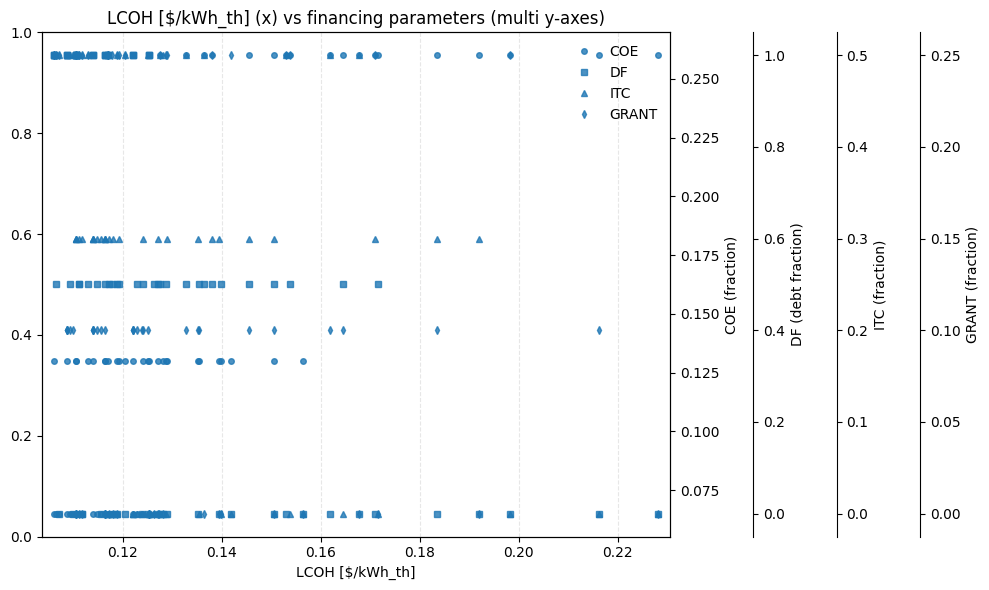

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _pick_value_col(df):
    candidates = [
        'LCOE_[$/kWh_e]',
        'LCOE_real_USD_kWh',
        'LCOH_[$/kWh_th]',
        'LCOH_real_USD_per_kWh_th',
    ]
    for c in candidates:
        if c in df.columns:
            return c
    for c in df.columns:
        if 'LCOE' in c or 'LCOH' in c:
            return c
    raise ValueError("Couldn't find an LCOE/LCOH column in df_sweep")

def plot_lcoh_vs_finance_multi_yaxes(df_sweep, value_col=None, metric_label="LCOH [$/kWh_th]"):
    df = df_sweep.copy()
    value_col = value_col or _pick_value_col(df)

    # Basic type cleanup
    for col in ['COE','DF','ITC','GRANT', value_col]:
        df[col] = df[col].astype(float)

    # Sort by x for nicer plotting
    df.sort_values(value_col, inplace=True)

    # Print global best
    best_idx = df[value_col].idxmin()
    print(f"Best by {metric_label} (from column '{value_col}'):")
    print(df.loc[best_idx])

    # Figure + multiple right y-axes
    fig, axx = plt.subplots(figsize=(10,6))
    axx.set_xlabel(metric_label)  # relabeled to LCOH
    axx.set_title(f"{metric_label} (x) vs financing parameters (multi y-axes)")

    # Create 4 twinx axes
    ax_coe  = axx.twinx()
    ax_df   = axx.twinx()
    ax_itc  = axx.twinx()
    ax_gr   = axx.twinx()

    # Offset the extra right spines so they don't overlap
    ax_df.spines["right"].set_position(("outward", 60))
    ax_itc.spines["right"].set_position(("outward", 120))
    ax_gr.spines["right"].set_position(("outward", 180))

    # Make extra axes frames invisible except their right spine
    def _only_right_spine(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for s in ax.spines.values():
            s.set_visible(False)
        ax.spines['right'].set_visible(True)

    _only_right_spine(ax_df)
    _only_right_spine(ax_itc)
    _only_right_spine(ax_gr)

    # Plot scatters for each param against the chosen metric
    h1 = ax_coe.plot(df[value_col], df['COE'],  'o', markersize=4, alpha=0.8, label='COE')
    h2 = ax_df.plot (df[value_col], df['DF'],   's', markersize=4, alpha=0.8, label='DF')
    h3 = ax_itc.plot(df[value_col], df['ITC'],  '^', markersize=4, alpha=0.8, label='ITC')
    h4 = ax_gr.plot (df[value_col], df['GRANT'],'d', markersize=4, alpha=0.8, label='GRANT')

    # Axis labels
    ax_coe.set_ylabel('COE (fraction)')
    ax_df.set_ylabel('DF (debt fraction)')
    ax_itc.set_ylabel('ITC (fraction)')
    ax_gr.set_ylabel('GRANT (fraction)')

    # Nice x-limits/padding
    xmin, xmax = df[value_col].min(), df[value_col].max()
    dx = (xmax - xmin) if xmax > xmin else (xmax if xmax > 0 else 1.0)
    axx.set_xlim(xmin - 0.02*dx, xmax + 0.02*dx)

    # Vertical grid on x to help reading y’s
    axx.grid(axis='x', linestyle='--', alpha=0.3)

    # One combined legend
    handles = h1 + h2 + h3 + h4
    labels = [h.get_label() for h in handles]
    ax_gr.legend(handles, labels, loc='upper right', frameon=False)

    plt.tight_layout()
    plt.show()

# ---- usage ----
# Using LCOE column but labeling as LCOH on the plot:
plot_lcoh_vs_finance_multi_yaxes(df_sweep, value_col='LCOE_[$/kWh_e]', metric_label="LCOH [$/kWh_th]")

# Or if you already have an LCOH column:
# plot_lcoh_vs_finance_multi_yaxes(df_sweep, value_col='LCOH_[$/kWh_th]')


C:\Users\tljohn\AppData\Local\Temp\ipykernel_20028\618431987.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


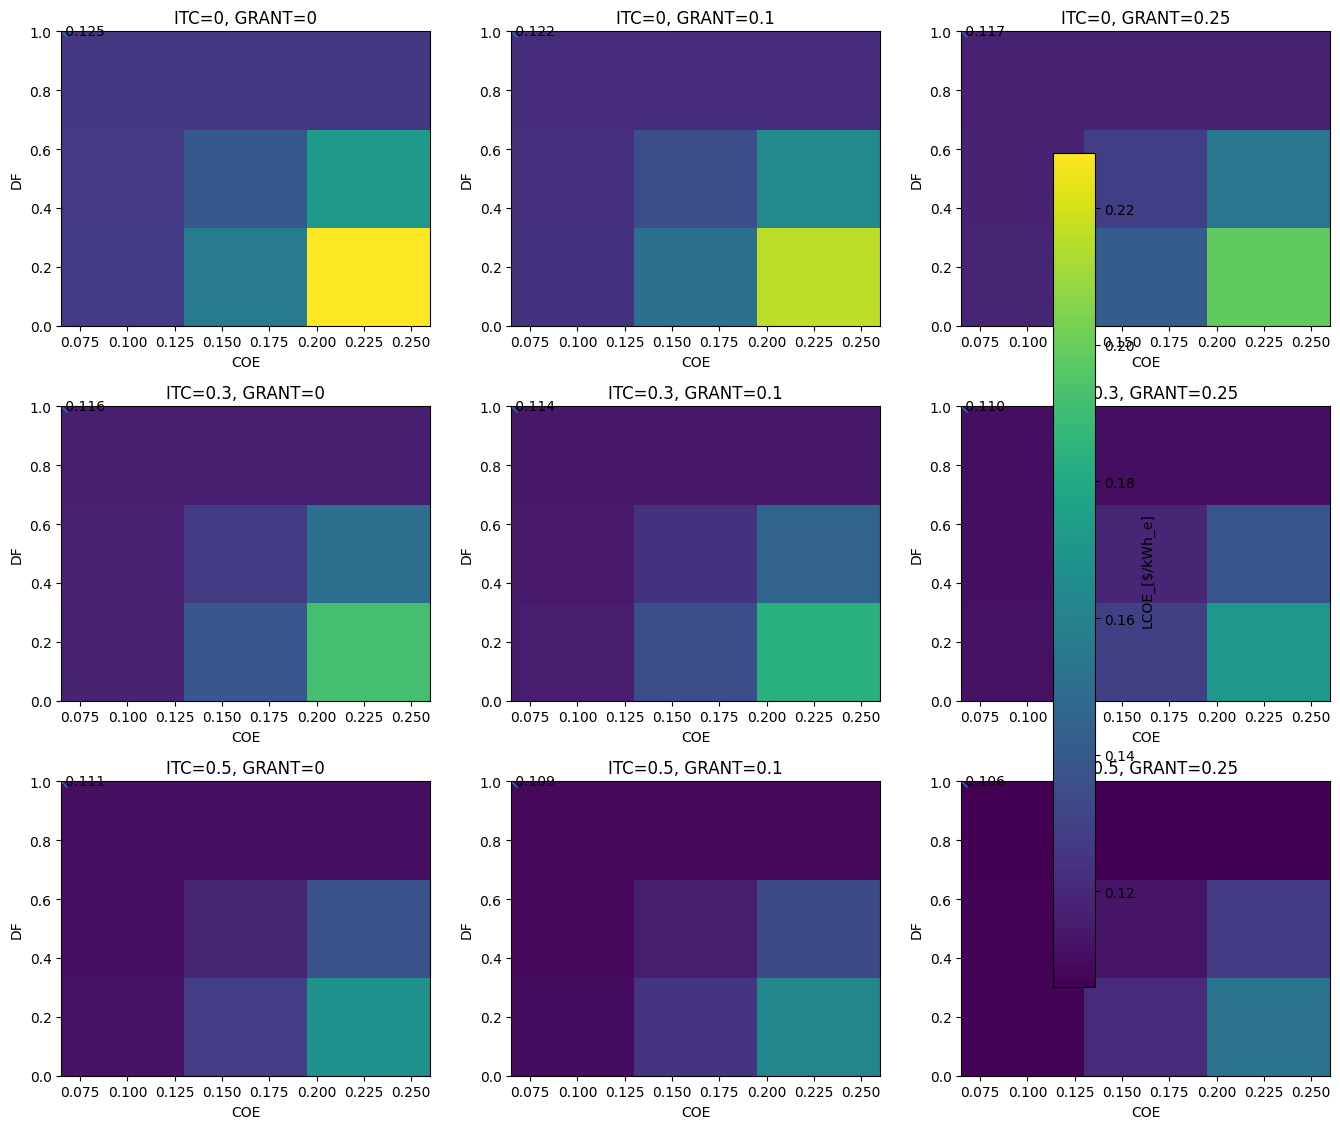

In [43]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _pick_value_col(df):
    for c in ['LCOH_[$/kWh_th]','LCOH_real_USD_per_kWh_th','LCOE_[$/kWh_e]','LCOE_real_USD_kWh']:
        if c in df.columns: return c
    for c in df.columns:
        if 'LCOE' in c or 'LCOH' in c: return c
    raise ValueError("No LCOE/LCOH column found.")

def plot_finance_heatmap_panels(df_sweep, value_col=None, annotate_min=True):
    df = df_sweep.copy()
    vcol = value_col or _pick_value_col(df)

    for col in ['COE','DF','ITC','GRANT', vcol]:
        df[col] = df[col].astype(float)

    xs = np.sort(df['COE'].unique())
    ys = np.sort(df['DF'].unique())
    itcs   = np.sort(df['ITC'].unique())
    grants = np.sort(df['GRANT'].unique())

    nrows, ncols = len(itcs), len(grants)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 3.8*nrows), squeeze=False)

    vmin, vmax = df[vcol].min(), df[vcol].max()

    for i, itc in enumerate(itcs):
        for j, gr in enumerate(grants):
            ax = axes[i, j]
            dfg = df[(df['ITC']==itc) & (df['GRANT']==gr)]
            piv = dfg.pivot_table(index='DF', columns='COE', values=vcol, aggfunc='min').reindex(index=ys, columns=xs)

            im = ax.imshow(piv.values, origin='lower', aspect='auto',
                           extent=[xs.min(), xs.max(), ys.min(), ys.max()],
                           vmin=vmin, vmax=vmax)
            ax.set_xlabel("COE")
            ax.set_ylabel("DF")
            ax.set_title(f"ITC={itc:g}, GRANT={gr:g}")

            if annotate_min and np.isfinite(piv.values).any():
                midx = np.nanargmin(piv.values)
                r, c = np.unravel_index(midx, piv.values.shape)
                ax.plot(piv.columns[c], piv.index[r], marker='x', markersize=9)
                ax.text(piv.columns[c], piv.index[r], f" {piv.values[r, c]:.3f}", va='center')

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    cbar.set_label(vcol)
    plt.tight_layout(); plt.show()

# Usage:
plot_finance_heatmap_panels(df_sweep)  # auto-detects LCOE/LCOH column


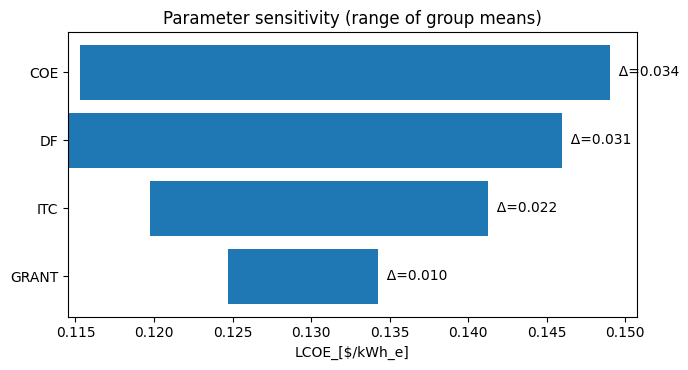

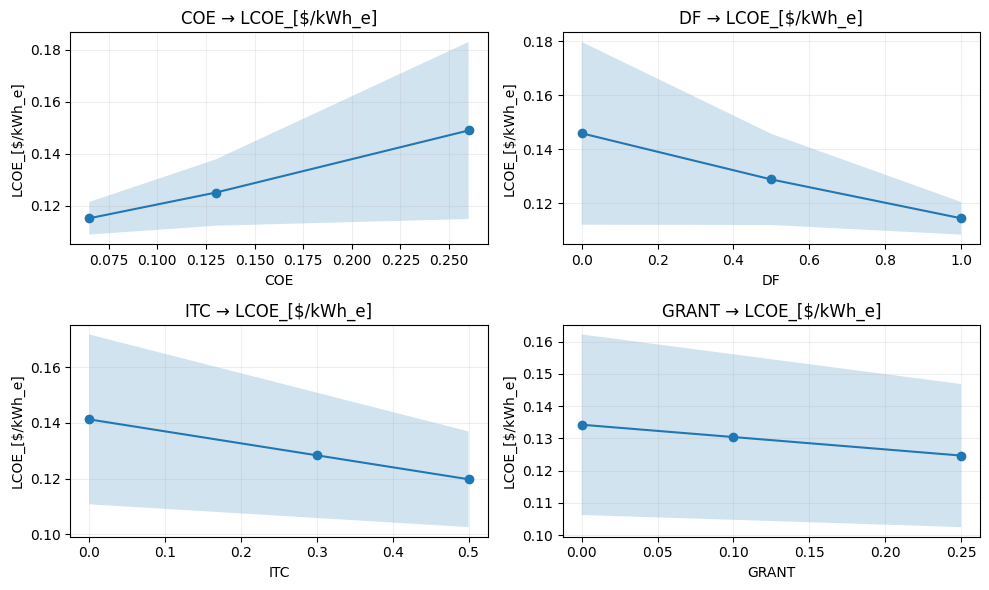

In [45]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _value_col(df):
    for c in ['LCOH_[$/kWh_th]','LCOH_real_USD_per_kWh_th','LCOE_[$/kWh_e]','LCOE_real_USD_kWh']:
        if c in df.columns: return c
    for c in df.columns:
        if 'LCOE' in c or 'LCOH' in c: return c
    raise ValueError

def tornado_and_marginals(df_sweep, value_col=None):
    df = df_sweep.copy()
    vcol = value_col or _value_col(df)
    params = ['COE','DF','ITC','GRANT']
    for c in params+[vcol]:
        df[c] = df[c].astype(float)

    # Tornado: range of the param’s group-mean LCOE/LCOH across its levels
    rows = []
    for p in params:
        g = df.groupby(p)[vcol].mean()
        rows.append((p, g.min(), g.max(), g.max()-g.min(), g.mean()))
    torn = pd.DataFrame(rows, columns=['param','min','max','range','mean']).sort_values('range', ascending=True)

    # Plot tornado
    fig, ax = plt.subplots(figsize=(7,3.8))
    y = np.arange(len(torn))
    ax.barh(y, torn['range'], left=torn['min'])
    ax.set_yticks(y); ax.set_yticklabels(torn['param'])
    ax.set_xlabel(vcol); ax.set_title("Parameter sensitivity (range of group means)")
    for yi,(mn,mx) in enumerate(zip(torn['min'], torn['max'])):
        ax.text(mx, yi, f"  Δ={mx-mn:.3f}", va='center')
    plt.tight_layout(); plt.show()

    # Marginal effects: per-parameter mean ± std band vs level
    fig, axes = plt.subplots(2,2, figsize=(10,6))
    axes = axes.ravel()
    for k,p in enumerate(params):
        stats = df.groupby(p)[vcol].agg(['mean','std','count']).reset_index().sort_values(p)
        x = stats[p].values; mu = stats['mean'].values; sd = stats['std'].values
        ax = axes[k]
        ax.plot(x, mu, marker='o')
        if np.isfinite(sd).all():
            ax.fill_between(x, mu-sd, mu+sd, alpha=0.2)
        ax.set_xlabel(p); ax.set_ylabel(vcol); ax.set_title(f"{p} → {vcol}")
        ax.grid(alpha=0.2)
    plt.tight_layout(); plt.show()

# Usage:
tornado_and_marginals(df_sweep)


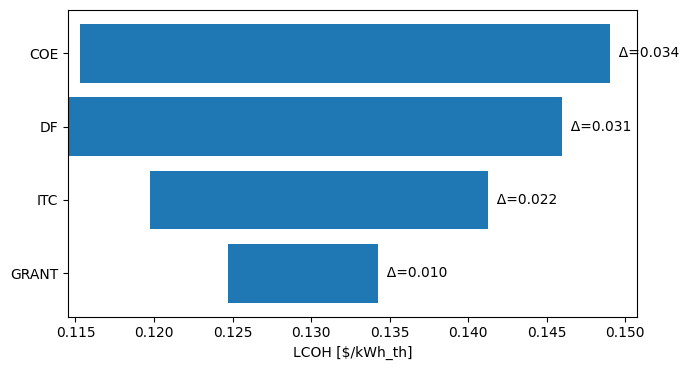

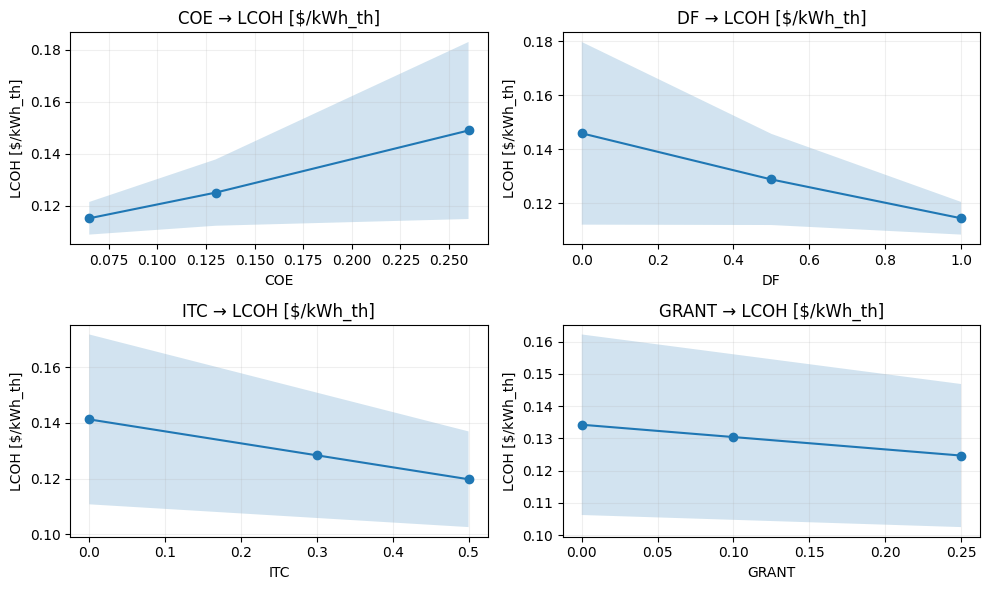

In [52]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _value_col(df):
    for c in ['LCOH_[$/kWh_th]','LCOH_real_USD_per_kWh_th','LCOE_[$/kWh_e]','LCOE_real_USD_kWh']:
        if c in df.columns: return c
    for c in df.columns:
        if 'LCOE' in c or 'LCOH' in c: return c
    raise ValueError("No LCOE/LCOH column found.")

def tornado_and_marginals(df_sweep, value_col=None, metric_label="LCOH [$/kWh_th]"):
    df = df_sweep.copy()
    vcol = value_col or _value_col(df)
    params = ['COE','DF','ITC','GRANT']
    for c in params+[vcol]:
        df[c] = df[c].astype(float)

    # Tornado: range of the param’s group-mean across its levels
    rows = []
    for p in params:
        g = df.groupby(p, dropna=False)[vcol].mean()
        rows.append((p, g.min(), g.max(), g.max()-g.min(), g.mean()))
    torn = pd.DataFrame(rows, columns=['param','min','max','range','mean']).sort_values('range', ascending=True)

    # Plot tornado
    fig, ax = plt.subplots(figsize=(7,3.8))
    y = np.arange(len(torn))
    ax.barh(y, torn['range'], left=torn['min'])
    ax.set_yticks(y); ax.set_yticklabels(torn['param'])
    ax.set_xlabel(metric_label)  # relabeled
    #ax.set_title(f"Parameter sensitivity (range of group means) — {metric_label}")
    for yi,(mn,mx) in enumerate(zip(torn['min'], torn['max'])):
        ax.text(mx, yi, f"  Δ={mx-mn:.3f}", va='center')
    plt.tight_layout(); plt.show()

    # Marginal effects: per-parameter mean ± std band vs level
    fig, axes = plt.subplots(2,2, figsize=(10,6))
    axes = axes.ravel()
    for k,p in enumerate(params):
        stats = df.groupby(p, dropna=False)[vcol].agg(['mean','std','count']).reset_index().sort_values(p)
        x = stats[p].values; mu = stats['mean'].values; sd = stats['std'].values
        ax = axes[k]
        ax.plot(x, mu, marker='o')
        if np.isfinite(sd).all():
            ax.fill_between(x, mu-sd, mu+sd, alpha=0.2)
        ax.set_xlabel(p); ax.set_ylabel(metric_label)  # relabeled
        ax.set_title(f"{p} → {metric_label}")
        ax.grid(alpha=0.2)
    plt.tight_layout(); plt.show()

# Usage examples:
tornado_and_marginals(df_sweep)  # auto-detects column, labels as LCOH
# tornado_and_marginals(df_sweep, value_col='LCOE_[$/kWh_e]', metric_label='LCOH [$/kWh_th]')


Best by LCOE_[$/kWh_e]:
COE                 0.065
ITC                   0.5
DF                    1.0
GRANT                0.25
LCOE_[$/kWh_e]    0.10606
aspect_ratio        1-1.5
rR                  0.914
Name: 26, dtype: object


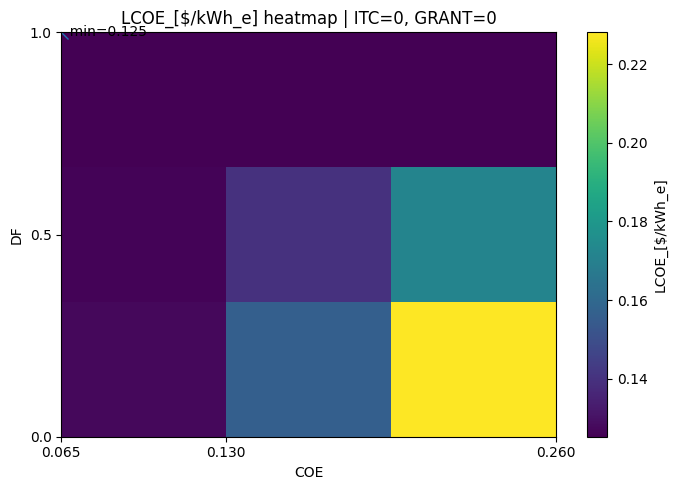

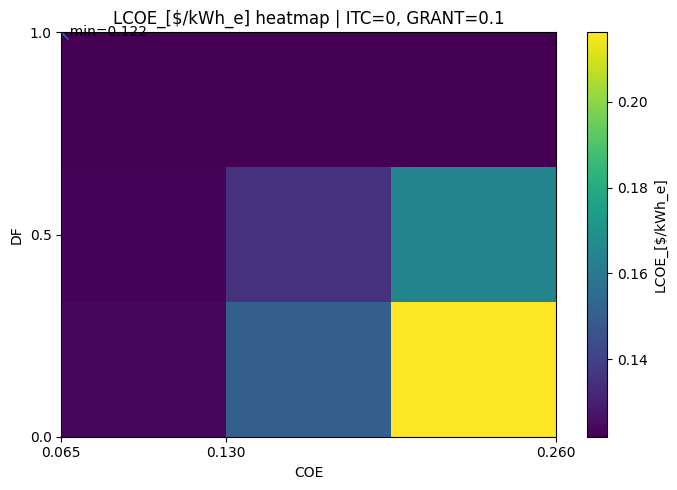

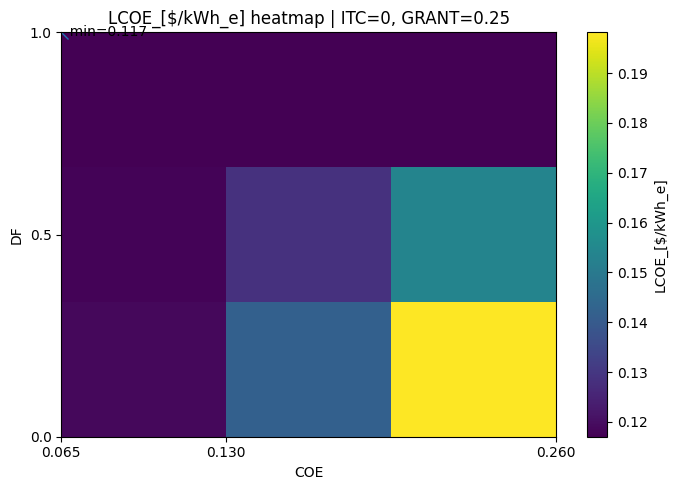

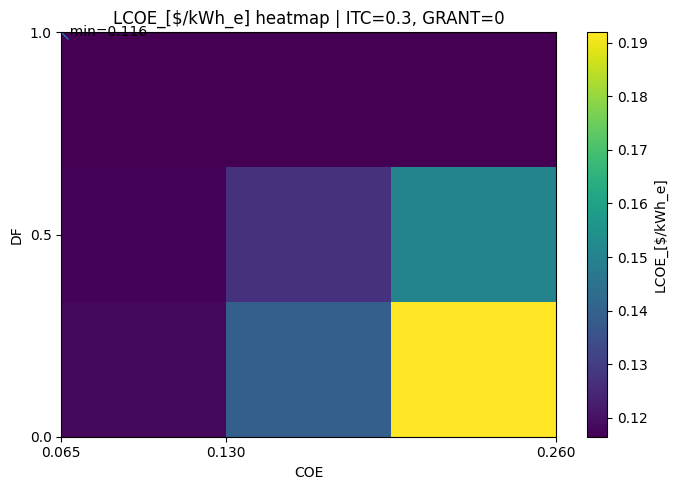

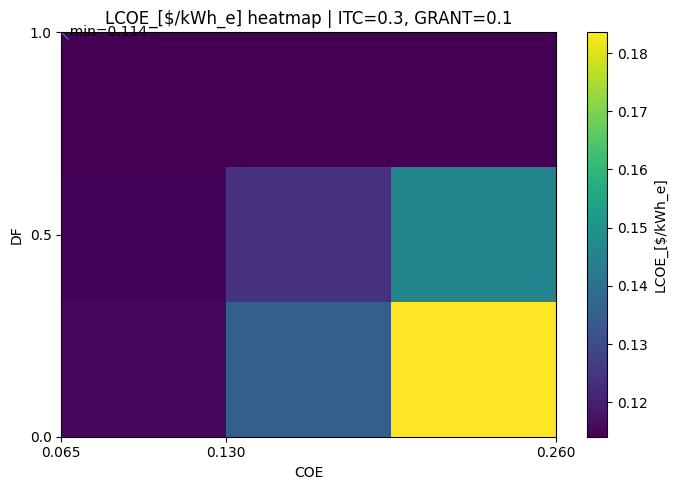

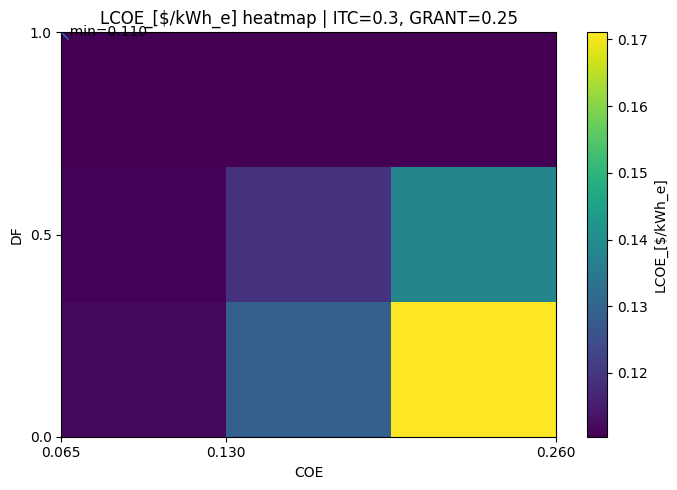

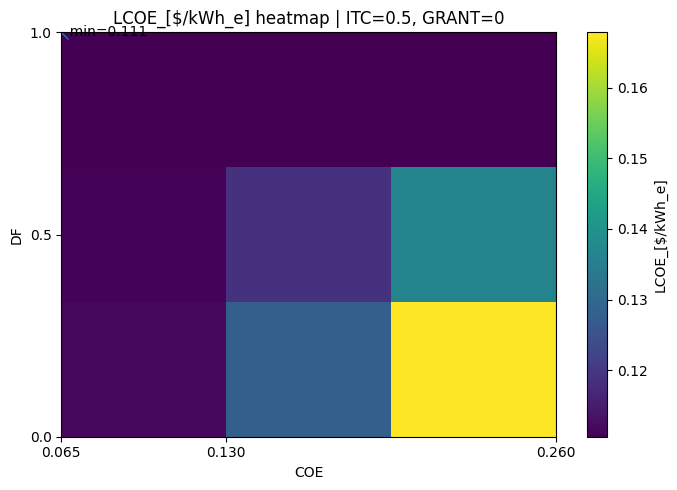

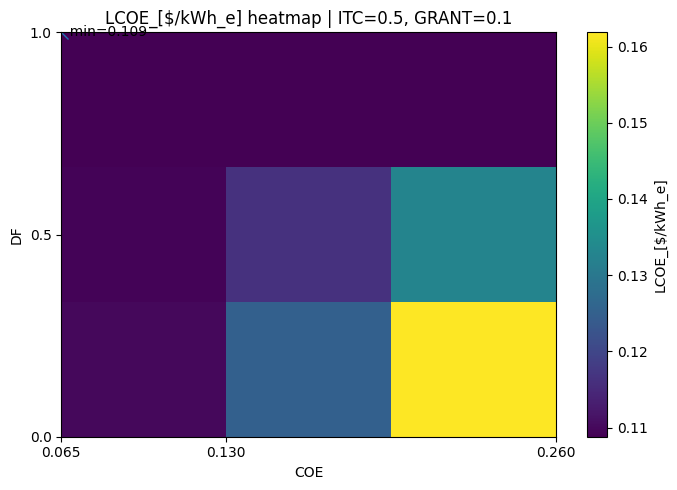

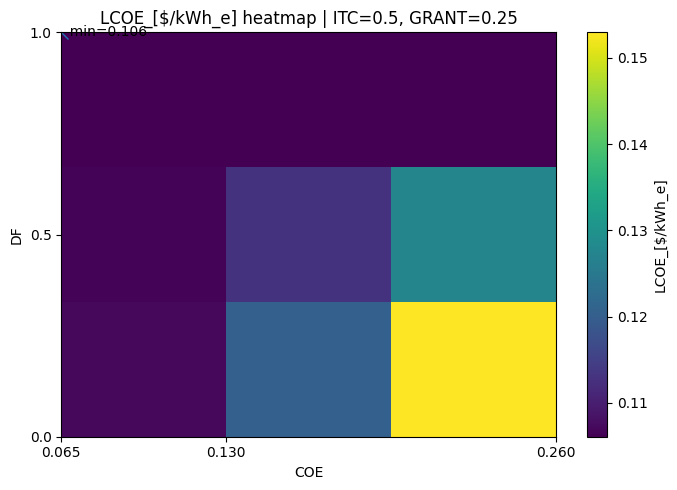

Best by LCOE_[$/kWh_e]:
COE                 0.065
ITC                   0.5
DF                    1.0
GRANT                0.25
LCOE_[$/kWh_e]    0.10606
aspect_ratio        1-1.5
rR                  0.914
Name: 26, dtype: object


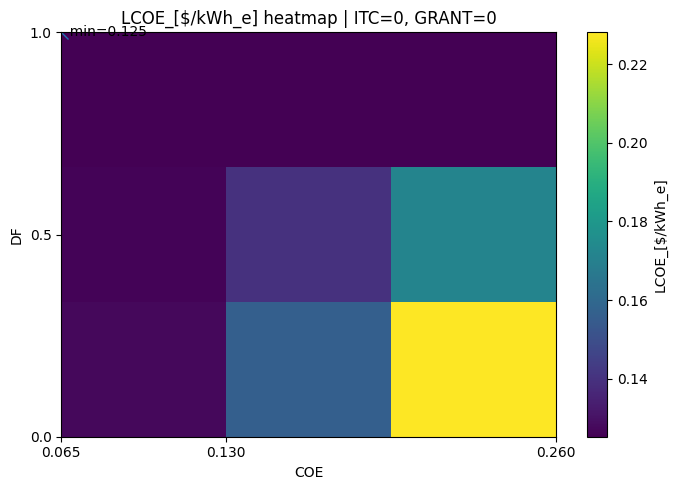

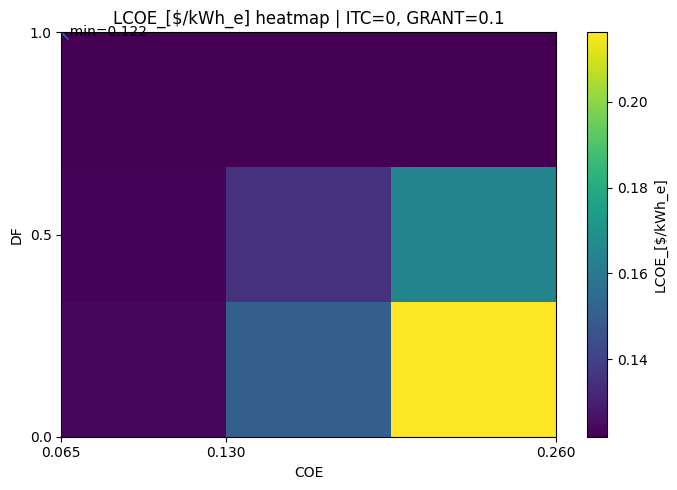

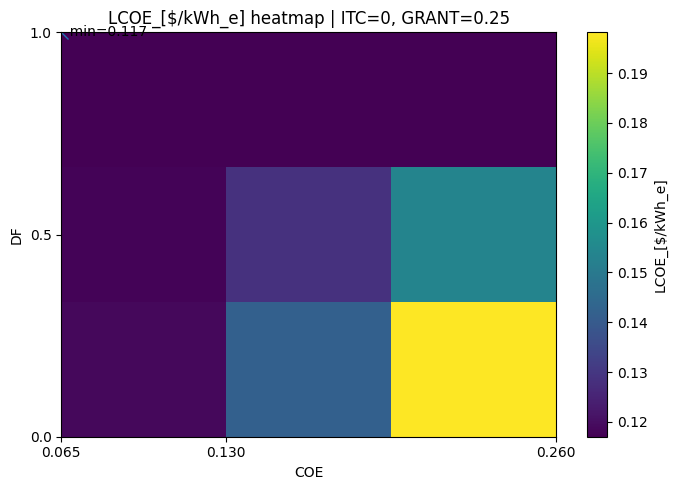

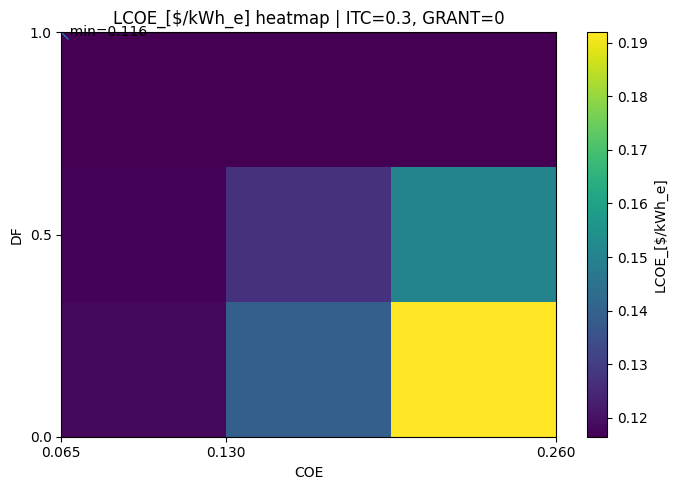

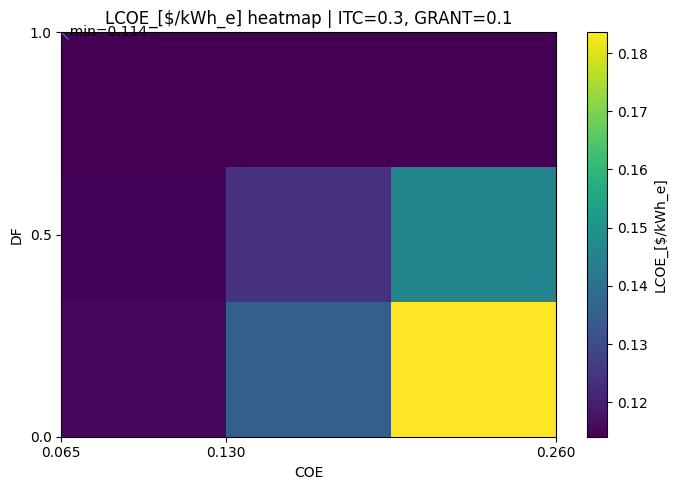

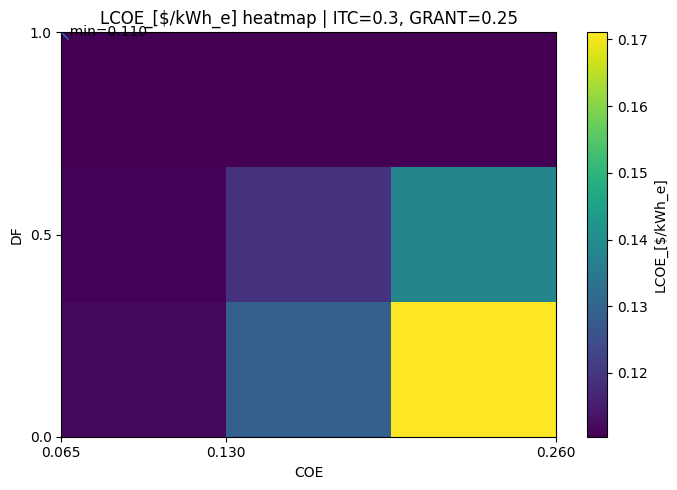

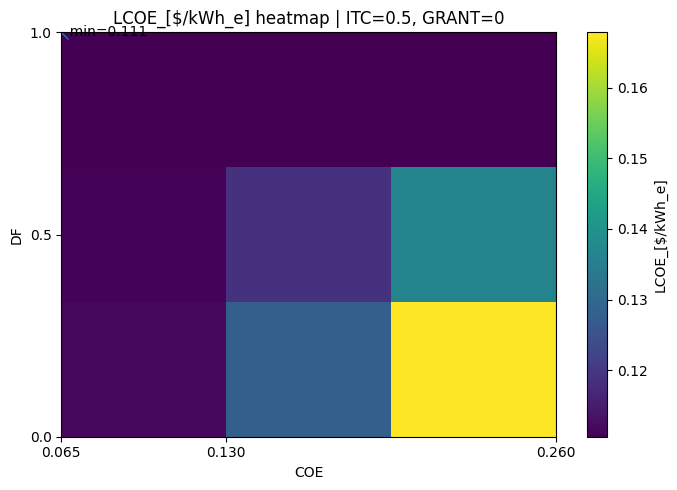

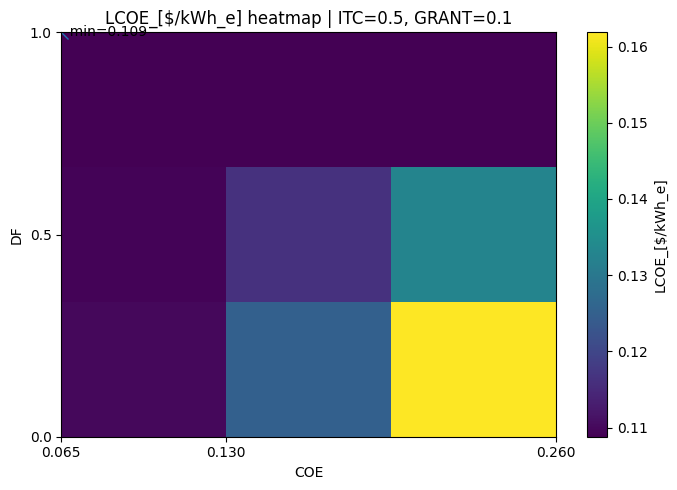

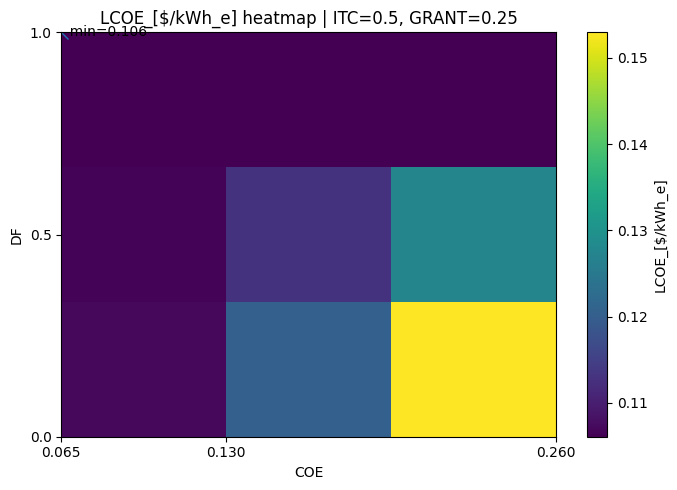

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _pick_value_col(df):
    # Try common names first
    preferred = [
        'LCOH_[$/kWh_th]',
        'LCOH_real_USD_per_kWh_th',
        'LCOE_[$/kWh_e]',
        'LCOE_real_USD_kWh',
    ]
    for c in preferred:
        if c in df.columns:
            return c
    # Fallback: any column containing LCOE/LCOH
    lc_cols = [c for c in df.columns if 'LCOE' in c or 'LCOH' in c]
    if lc_cols:
        return lc_cols[0]
    raise ValueError("Couldn't find an LCOE/LCOH column in df_sweep.")

def plot_finance_heatmaps(df_sweep, value_col=None):
    df = df_sweep.copy()

    # Auto-detect metric column if not provided
    value_col = value_col or _pick_value_col(df)

    # Basic checks
    needed = {'COE','DF','ITC','GRANT', value_col}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"df_sweep is missing columns: {missing}")

    # Sort numeric axes for consistent grids
    df['COE'] = df['COE'].astype(float)
    df['DF']  = df['DF'].astype(float)
    df['ITC'] = df['ITC'].astype(float)
    df['GRANT'] = df['GRANT'].astype(float)

    # Print global best
    best_idx = df[value_col].idxmin()
    print("Best by {}:".format(value_col))
    print(df.loc[best_idx])

    # Unique panels
    itcs   = np.sort(df['ITC'].unique())
    grants = np.sort(df['GRANT'].unique())

    # Axes grids
    xs = np.sort(df['COE'].unique())
    ys = np.sort(df['DF'].unique())

    for itc in itcs:
        for gr in grants:
            dfg = df[(df['ITC']==itc) & (df['GRANT']==gr)]
            if dfg.empty:
                continue

            # Pivot to (DF × COE) grid
            piv = dfg.pivot_table(index='DF', columns='COE', values=value_col, aggfunc='min').reindex(index=ys, columns=xs)

            fig, ax = plt.subplots(figsize=(7,5))
            im = ax.imshow(piv.values, origin='lower', aspect='auto',
                           extent=[xs.min(), xs.max(), ys.min(), ys.max()])

            ax.set_title(f"{value_col} heatmap | ITC={itc:g}, GRANT={gr:g}")
            ax.set_xlabel("COE")
            ax.set_ylabel("DF")

            # Ticks at actual grid points (limit count if lots)
            xticks = xs if len(xs) <= 10 else xs[::max(1,len(xs)//10)]
            yticks = ys if len(ys) <= 10 else ys[::max(1,len(ys)//10)]
            ax.set_xticks(xticks)
            ax.set_yticks(yticks)

            # Annotate min in this panel
            if np.isfinite(piv.values).any():
                min_idx = np.unravel_index(np.nanargmin(piv.values), piv.values.shape)
                min_x = piv.columns[min_idx[1]]
                min_y = piv.index[min_idx[0]]
                ax.plot([min_x], [min_y], marker='x', markersize=10)
                ax.text(min_x, min_y, f"  min={piv.values[min_idx]:.3f}", va='center', ha='left')

            # Colorbar
            cbar = fig.colorbar(im, ax=ax)
            cbar.set_label(value_col)

            plt.tight_layout()
            plt.show()

# ---- Run it ----
plot_finance_heatmaps(df_sweep)           # auto-detects LCOE/LCOH column
plot_finance_heatmaps(df_sweep, 'LCOE_[$/kWh_e]')   # or specify explicitly
# plot_finance_heatmaps(df_sweep, 'LCOH_[$/kWh_th]')


In [30]:
best_row = df_sweep.loc[df_sweep['LCOE_[$/kWh_e]'].idxmin()]
best_row

COE                 0.065
ITC                   0.5
DF                    1.0
GRANT                0.25
LCOE_[$/kWh_e]    0.10606
aspect_ratio        1-1.5
rR                  0.914
Name: 26, dtype: object

In [31]:
# --- fixed finance knobs per your spec ---
set_finance_params(COE=0.065, DF=1.0, grant_frac=0.25)  # cost of equity, all-debt, grant 25%
ITC = 0.50                                              # pass into System(...)

# --- PV sizes to test (MW-AC). edit as you like ---
PV_capacity_AC_grid = [0.40]  # 50–400 kW
#0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, 0.20, 0.30, 

# --- fixed TES: 200 kWh, geometry 1-1.5 ---
geometry_data = {
    '1-1.5': {'tank_cost': 630, 'insulation_cost': 34, 'exergy_efficiency': 0.707, 'rR': 0.914},
}
ar = '1-1.5'
geo  = geometry_data[ar]
# be robust: treat values >1 as percentages, ≤1 as fractions
eff_raw = geo['exergy_efficiency']
eff = eff_raw if eff_raw <= 1.0 else eff_raw / 100.0
cost = geo['insulation_cost']
tank = geo['tank_cost']
rR   = geo['rR']

# --- constants that don’t change across PV sizes ---
ratio_MW2acres = {'SAT': 0.24, 'fixed': 0.35}
pv_type = 'fixed'
pv_dc2ac = 1.2 
POI_limit = None   # NOTE: if you want to treat *all excess* as curtailment (no export), set to 0
analysis_period = 25

# Site
NSTTF_site = Site('NSTTF', Weather_Data(Kfiles), -7, POI_limit=POI_limit)

# TES (fixed capacity)
TES_capacity_e = 200/1000   # 200 kWh -> 0.200 MWh
power_block = power_block_size  # keep your existing PB
df_sweep_PV = []

for PV_capacity_AC in PV_capacity_AC_grid:
    PV_capacity_DC = PV_capacity_AC * pv_dc2ac
    resistive_charge_rate = PV_capacity_DC

    # PV system (fresh instance each size)
    ASGARD_PV = PV_System(
        name='ASGARD_PV',
        site=NSTTF_site,
        capacity_MW_DC=PV_capacity_DC,
        PV_array_type=pv_type,
        PV_tilt=30,
        PV_azimuth=180,
        ratio_DC2AC=pv_dc2ac,
        off_grid_operation=False,
        power_priority_load_MW_AC=None
    )

    # TES system (fixed 200 kWh; same geometry)
    ASGARD_TES = TES_System_STM(
        name=f'ASGARD_TES_{ar}',
        site=NSTTF_site,
        capacity_MWh_t=TES_capacity_e/0.98,
        power_rating_MW_e=power_block,
        power_minimum_MW_e=0,
        efficiency_rating_t2e=eff,
        percent_discharge_depth=100,
        percent_heat_loss_daily=3,
        charge_rate_CSP_MW_t=0,
        charge_efficiency_t2TES=1,
        charge_rate_resistive_MW_e=resistive_charge_rate,
        charge_efficiency_e2TES=0.98,
        systems_charging=['ASGARD_PV'],
        start_full=False,
        off_grid_operation=True,
        DOE_2030_targets=False,
        tank_cost=tank,
        insulation_cost=cost,
        exergy_efficiency=eff,
        rR=rR
    )

    # Build and run
    systems = [ASGARD_PV, ASGARD_TES]
    sim = System(
        load_MW=greenhouse_load,
        systems_load_order=systems,
        analysis_period=analysis_period,
        ITC=ITC
    )
    m = sim.metrics
    # Pull PV curtailment/export and generation from the timeseries/metrics
    ts = sim.timeseries
    pv_name = ASGARD_PV.name

    # NOTE: With POI_limit=None, exports are unlimited, so curtailment will usually be ~0.
    # If you want to see “would-be curtailment” with no export, set POI_limit=0 above.
    curt_MWh   = float(m.get(f'{pv_name}_curtailed_MWh_e', 0.0))

    df_sweep_PV.append({
        'PV_capacity_AC_MW': PV_capacity_AC,
        'PV_capacity_DC_MW': PV_capacity_DC,
        'COE': 0.065,
        'ITC': 0.50,
        'DF': 1.0,
        'GRANT': 0.25,
        'aspect_ratio': ar,
        'rR': rR,
        'LCOE_[$/kWh_e]': m['LCOE_real_USD_kWh'],
        'PV_curtail_MWh': curt_MWh,
        'TES_to_load_MWh_e': m['TES_System_STM_to_load_MWh_e'],
        'TES_thermal_loss_MWh_t': m['TES_System_STM_thermal_loss_MWh_t'],
    })

df_sweep_PV = pd.DataFrame(df_sweep_PV)
print(df_sweep_PV)

# Best by LCOE
best = df_sweep_PV.loc[df_sweep_PV['LCOE_[$/kWh_e]'].idxmin()]
print("\nBest by LCOE:\n", best)


c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09483041435734925' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,'fuel_to_load_MWh_th'] = unmet_load_MW
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:313: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0040698340311544475' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1,pv.name+'_to_load_MWh_e'] = pv2l
c:\Users\tljohn\Desktop\RPB Micmaq\code\system_stm.py:414: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0040698340311544475' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame()
# TEA system setup
ratio_MW2acres = {'SAT': 0.24, 'fixed': 0.35}
pv_type = 'fixed'
pv_dc2ac = 1.2 
POI_limit = None  
analysis_period = 25  
ITC = 0.3  

# Setup Site and Systems
NSTTF_site = Site('NSTTF', Weather_Data(Kfiles), -7, POI_limit=POI_limit)
power_block = power_block_size # MW
PV_capacity_AC = 0.1 
PV_capacity_DC = PV_capacity_AC * pv_dc2ac  
ASGARD_PV = PV_System(
    name='ASGARD_PV',
    site=NSTTF_site,
    capacity_MW_DC=PV_capacity_DC,
    PV_array_type=pv_type,
    PV_tilt=30,
    PV_azimuth=180,
    ratio_DC2AC=pv_dc2ac,
    off_grid_operation=False,
    power_priority_load_MW_AC=None
)

TES_capacity_e = 200/1000 # MWh
resistive_charge_rate = PV_capacity_DC

aspect_ratios = list(geometry_data.keys())

all_timeseries = {}

all_LCOH = {}
for ar in aspect_ratios:
    geo  = geometry_data[ar]
    eff  = geo['exergy_efficiency']
    cost = geo['insulation_cost']
    tank = geo['tank_cost']
    rR = geo['rR']

    ASGARD_TES = TES_System_STM(
        name=f'ASGARD_TES_{ar}',
        site=NSTTF_site,
        capacity_MWh_t=TES_capacity_e/0.98,
        power_rating_MW_e=power_block,
        power_minimum_MW_e=0,
        efficiency_rating_t2e=eff, # change to correspond to the different systems exergy efficiency for each system
        percent_discharge_depth=100,
        percent_heat_loss_daily=3, # calc from daily heat loss / 200 kWh
        charge_rate_CSP_MW_t=0,
        charge_efficiency_t2TES=1,
        charge_rate_resistive_MW_e=resistive_charge_rate,
        charge_efficiency_e2TES=0.98,
        systems_charging=['ASGARD_PV'],
        start_full=False,
        off_grid_operation=True,
        DOE_2030_targets=False,
        tank_cost=tank,
        insulation_cost=cost,
        exergy_efficiency=eff,
        rR = rR
    )
    
    systems = [ASGARD_PV, ASGARD_TES]
    NSTTF = System(
        load_MW=greenhouse_load,
        systems_load_order=systems,
        analysis_period=analysis_period,
        ITC=ITC
    )

    metrics = NSTTF.metrics
    all_keys = list(metrics.keys())
    print(all_keys)
    d = pd.DataFrame({
    'aspect_ratio': ar,
    'rR': rR,
    'LCOE_real_USD_kWh': metrics['LCOE_real_USD_kWh'],
    'TES_System_STM_thermal_loss_MWh_t' : metrics['TES_System_STM_thermal_loss_MWh_t'],
    'TES_System_STM_to_load_MWh_e' : metrics['TES_System_STM_to_load_MWh_e'],
    }, index=[0])
    
    df = pd.concat([df, d], ignore_index=True)

NameError: name 'TES_System_STM' is not defined

In [ ]:
df
df = df.rename(columns={'LCOE_real_USD_kWh': 'LCOH [$/kWh]'})

In [ ]:
df

,aspect_ratio,rR,LCOH [$/kWh],TES_System_STM_thermal_loss_MWh_t,TES_System_STM_to_load_MWh_e
0,3-1,0.5740,0.089254,0.598736,34.307241
1,2.5-1,0.6060,0.088908,0.603063,35.608174
2,2-1,0.6480,0.088562,0.607369,36.908921
3,1.5-1,0.7080,0.088201,0.611912,38.265978
4,1-1,0.8040,0.087845,0.616394,39.622858
5,1-1.5,0.9140,0.087693,0.618431,40.244702
6,1-2,1.0019,0.087706,0.618431,40.244702
7,1-2.5,1.0770,0.087765,0.617875,40.075113
8,1-3,1.1420,0.087870,0.616764,39.735924
